In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
#Setup
PCA_COMPONENTS=50
RANDOM_SEED=2

In [3]:
# Load CCLE Data
ccle = pd.read_csv("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz", sep="\t", engine='c')
ccle_data = ccle.iloc[:,2:]
ccle_data_log2 = np.log2(ccle_data + 1)
ccle_lineages = [x.split(sep="_", maxsplit=1)[1] for x in ccle.columns[2:].tolist()]

In [4]:
# Basic stats
print(ccle_data.shape)
print(len(set(ccle_lineages)))

(57820, 1019)
26


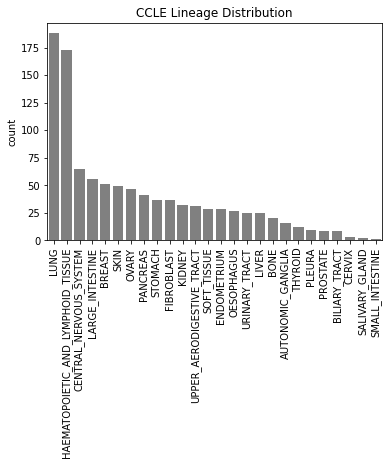

In [5]:
#Plot histogram of lineages
lineage_sorted_by_count = [x[0] for x in Counter(ccle_lineages).most_common()]
ax = sns.countplot(ccle_lineages, color = 'gray', order = lineage_sorted_by_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('CCLE Lineage Distribution')
ax.figure.savefig('../fig/ccle_lineage_histogram.png', bbox_inches = "tight")

In [6]:
#Run PCA
ccle_pca = PCA(n_components=PCA_COMPONENTS, svd_solver="full").fit_transform(ccle_data_log2.transpose())
ccle_pca_df = pd.DataFrame(data = ccle_pca)
ccle_pca_df['Lineage'] = ccle_lineages
ccle_pca_df['isHaem'] = ccle_pca_df['Lineage'] == 'HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'

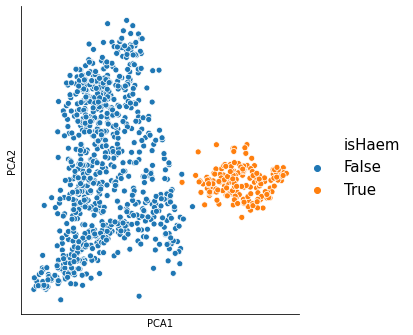

In [7]:
#Plot PCA
with sns.plotting_context(rc={"legend.fontsize":15}):
    ax = sns.relplot(x=0, y=1, data=ccle_pca_df, hue = "isHaem")
    ax.set(xlabel="PCA1", ylabel = "PCA2", xticks=[], yticks=[])
    
ax.savefig('../fig/ccle_pca.png')

In [8]:
#CCLE TSNE
ccle_tsne_list = []
for PERPLEXITY in [50,30,10,5]:
    this_ccle_tsne = TSNE(n_components=2, perplexity=PERPLEXITY, random_state=RANDOM_SEED).fit_transform(ccle_pca)
    this_ccle_tsne_df = pd.DataFrame(data = this_ccle_tsne, columns=['tsne1','tsne2'])
    this_ccle_tsne_df['Lineage'] = ccle_lineages
    this_ccle_tsne_df['isHaem'] = this_ccle_tsne_df['Lineage'] == 'HAEMATOPOIETIC_AND_LYMPHOID_TISSUE'
    this_ccle_tsne_df['PERPLEXITY'] = PERPLEXITY
    ccle_tsne_list.append(this_ccle_tsne_df)
    
ccle_tsne_list_all = pd.concat(ccle_tsne_list, axis=0, ignore_index=True)

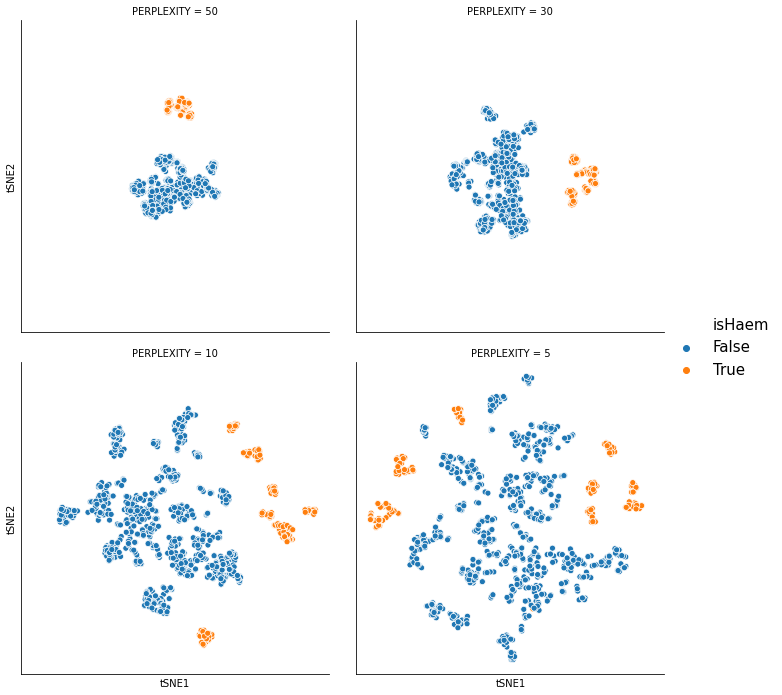

In [9]:
with sns.plotting_context(rc={"legend.fontsize":15}):
    ax = sns.relplot(x='tsne1', y='tsne2', data=ccle_tsne_list_all, hue = 'isHaem', col='PERPLEXITY', col_wrap=2, col_order=[50,30,10,5])
    ax.set(xlabel="tSNE1", ylabel = "tSNE2", xticks=[], yticks=[])
    
ax.savefig('../fig/ccle_tsne.png')

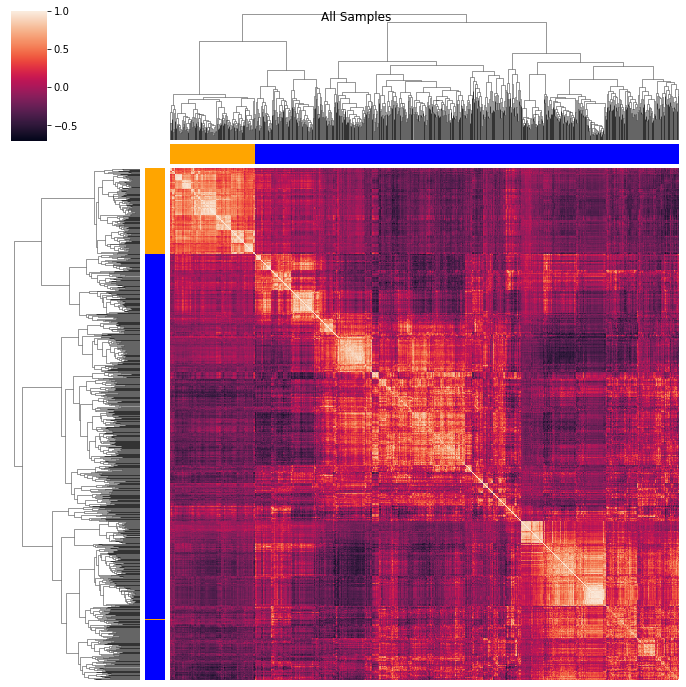

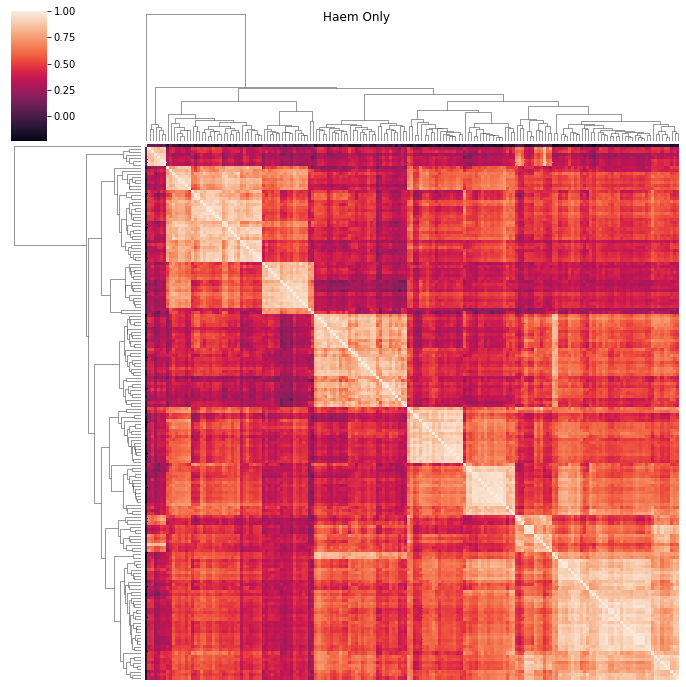

In [11]:
#Make clustermaps of all samples and Haem Only
color_bar = np.where(ccle_pca_df['isHaem'], 'orange', 'blue')

#All
cm_all = sns.clustermap(ccle_pca_df.iloc[:,0:49].transpose().corr(), col_colors = color_bar, row_colors=color_bar)
cm_all.fig.suptitle('All Samples')
cm_all.ax_heatmap.set(yticks=[], yticklabels='',xticks=[], xticklabels='')
cm_all.savefig('../fig/ccle_clustermap_all.png')

#Haem
cm_haem = sns.clustermap(ccle_pca_df.loc[ccle_pca_df['isHaem'] == True,].iloc[:,0:49].transpose().corr())
cm_haem.fig.suptitle('Haem Only')
cm_haem.ax_heatmap.set(yticks=[], yticklabels='',xticks=[], xticklabels='')
cm_haem.savefig('../fig/ccle_clustermap_haem.png')